In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from fredapi import Fred
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


In [ ]:
fred = Fred(api_key='abc123yourapikey')

[*********************100%***********************]  1 of 1 completed


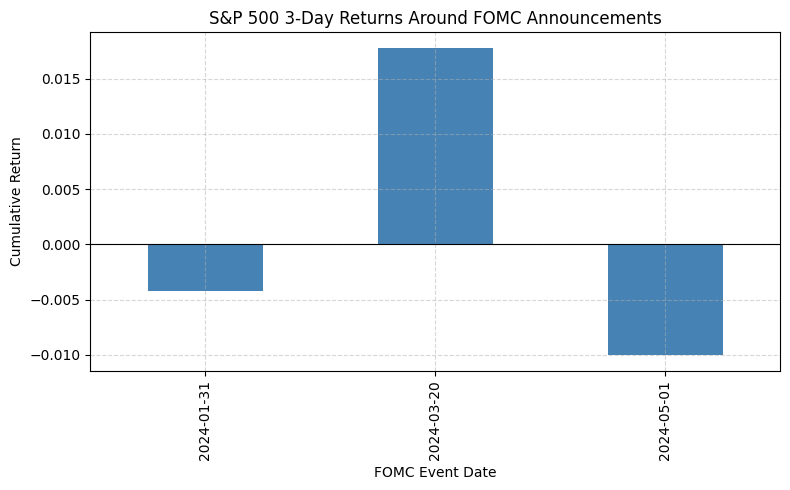

In [18]:
# Sample FOMC dates
fomc_dates = ["2024-01-31", "2024-03-20", "2024-05-01"]
fomc_dates = pd.to_datetime(fomc_dates)

# Download S&P 500 index data
spx = yf.download("^GSPC", start="2023-12-01", end="2024-06-01")

# Use 'Adj Close' if available, else fall back to 'Close'
price_col = 'Adj Close' if 'Adj Close' in spx.columns else 'Close'
spx['Return'] = spx[price_col].pct_change()

# Analyze 3-day cumulative returns around FOMC dates
window = 1
event_returns = []

for date in fomc_dates:
    try:
        # Align to nearest market date
        aligned_date = spx.index[spx.index.get_indexer([date], method='nearest')[0]]
        idx = spx.index.get_loc(aligned_date)
        ret = spx['Return'].iloc[idx - window : idx + window + 1].sum()
        event_returns.append((aligned_date.date(), ret))
    except Exception as e:
        print(f"Skipping {date.date()} due to: {e}")
        continue

# Plot
event_df = pd.DataFrame(event_returns, columns=["Date", "3-Day Return"])
event_df.set_index("Date", inplace=True)

ax = event_df.plot(kind="bar", legend=False, color='steelblue', figsize=(8,5))
plt.title("S&P 500 3-Day Returns Around FOMC Announcements")
plt.ylabel("Cumulative Return")
plt.xlabel("FOMC Event Date")
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [19]:
# Sample macro event dates (e.g., CPI or FOMC announcements)
event_dates = pd.to_datetime([
    "2024-01-11", "2024-02-13", "2024-03-12",
    "2024-04-10", "2024-05-15", "2024-06-12"
])

# Define multiple return horizons (1-day, 3-day, 5-day)
horizons = [1, 3, 5]
event_returns = []

for date in event_dates:
    try:
        idx = spx.index.get_indexer([date], method='nearest')[0]
        actual_date = spx.index[idx]
        row = {"Date": actual_date}
        for h in horizons:
            window_return = spx['Return'].iloc[idx - h : idx + h + 1].sum()
            row[f"{2*h+1}D_Return"] = window_return
        event_returns.append(row)
    except Exception as e:
        print(f"Skipped {date} due to: {e}")
        continue

# Convert to DataFrame
event_df = pd.DataFrame(event_returns).set_index("Date")
display(event_df)

,3D_Return,7D_Return,11D_Return
Date,,,
2024-01-11,0.005746,0.009034,0.028550
2024-02-13,-0.005043,0.002287,0.008098
2024-03-12,0.008155,0.002577,0.009492
2024-04-10,-0.000567,-0.016414,-0.035494
2024-05-15,0.014472,0.017961,0.022842
2024-05-31,0.002053,-0.005065,-0.005445


In [20]:
cpi = fred.get_series('CPIAUCNS')  # All Urban Consumers CPI
cpi = cpi.resample('ME').last()
cpi_df = pd.DataFrame({'CPI': cpi})
cpi_df['CPI_YoY'] = cpi_df['CPI'].pct_change(12)
print(cpi_df['CPI_YoY'].tail(5))

2025-01-31    0.030005
2025-02-28    0.028215
2025-03-31    0.023907
2025-04-30    0.023113
2025-05-31    0.023549
Freq: ME, Name: CPI_YoY, dtype: float64


In [21]:
cpi_df['CPI_MoM'] = cpi_df['CPI'].pct_change()
# Add Fed Funds Rate
cpi_df['FedFunds'] = fred.get_series('FEDFUNDS').resample('ME').last()
cpi_df = cpi_df.dropna()
print(cpi_df.tail(5))

                CPI   CPI_YoY   CPI_MoM  FedFunds
2025-01-31  317.671  0.030005  0.006546      4.33
2025-02-28  319.082  0.028215  0.004442      4.33
2025-03-31  319.799  0.023907  0.002247      4.33
2025-04-30  320.795  0.023113  0.003114      4.33
2025-05-31  321.465  0.023549  0.002089      4.33


In [22]:
# Download full data with all columns
spx_full = yf.download("^GSPC", start="2000-01-01")

# Use 'Adj Close' if available, else fall back to 'Close'
spx_price = spx_full.get('Adj Close', spx_full.get('Close'))

# Monthly return
spx_ret = spx_price.pct_change().resample('ME').sum()

# Merge into your CPI dataframe
cpi_df['SPX_Return'] = spx_ret

# Create label for classification: 1 if return > 1%, else 0
cpi_df['Label'] = (cpi_df['SPX_Return'] > 0.01).astype(int)


[*********************100%***********************]  1 of 1 completed


In [23]:
X = cpi_df[['CPI_YoY', 'CPI_MoM', 'FedFunds']]
y = cpi_df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [24]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.4647887323943662

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.96      0.62        97
           1       0.60      0.05      0.10       116

    accuracy                           0.46       213
   macro avg       0.53      0.51      0.36       213
weighted avg       0.54      0.46      0.33       213



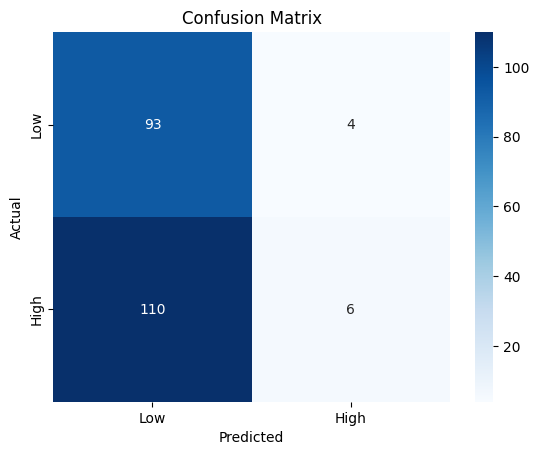

In [25]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Low", "High"], yticklabels=["Low", "High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

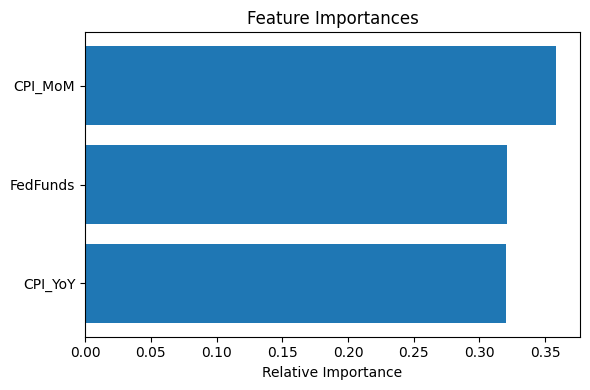

In [26]:
features = X.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6, 4))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

In [27]:
# Get prediction probabilities
y_prob = clf.predict_proba(X_test)[:, 1]  # Probability of class "1" (high move)

# Set custom threshold
threshold = 0.65
signals = (y_prob > threshold).astype(int)

# Compare signals vs actual
signal_df = pd.DataFrame({
    "Prob_HighMove": y_prob,
    "Signal": signals,
    "Actual": y_test.values,
    "SPX_Return": cpi_df.loc[y_test.index, 'SPX_Return']
    })


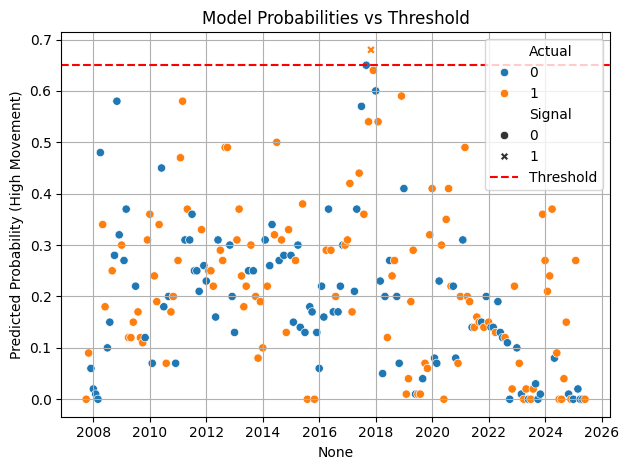

In [28]:
sns.scatterplot(x=signal_df.index, y=signal_df['Prob_HighMove'], hue=signal_df['Actual'], style=signal_df['Signal'])
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Model Probabilities vs Threshold")
plt.ylabel("Predicted Probability (High Movement)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  Part 2: Backtested Straddle Strategy Based on ML Signal

In [29]:
# Parameters
premium = 0.02  # Example 2% premium cost

# Simulate straddle P&L
signal_df['Straddle_PnL'] = signal_df.apply(
    lambda row: abs(row['SPX_Return']) - premium if row['Signal'] == 1 else 0,
    axis=1
)

# Filter to strategy entries
active_trades = signal_df[signal_df['Signal'] == 1]

# Results
print("Total Trades:", len(active_trades))
print("Average P&L:", active_trades['Straddle_PnL'].mean())
print("Winning %:", (active_trades['Straddle_PnL'] > 0).mean())

Total Trades: 1
Average P&L: 0.0020543938517168132
Winning %: 1.0


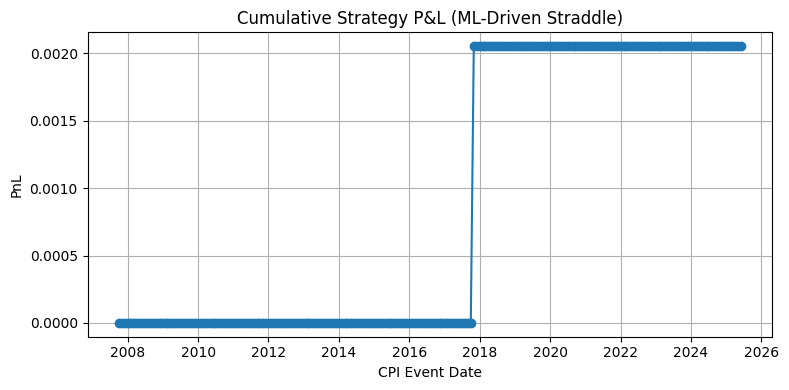

In [30]:
signal_df['Cumulative_PnL'] = signal_df['Straddle_PnL'].cumsum()

plt.figure(figsize=(8, 4))
plt.plot(signal_df.index, signal_df['Cumulative_PnL'], marker='o')
plt.title("Cumulative Strategy P&L (ML-Driven Straddle)")
plt.xlabel("CPI Event Date")
plt.ylabel("PnL")
plt.grid(True)
plt.tight_layout()
plt.show()